<a href="https://colab.research.google.com/github/Latamila/Series-Temporais/blob/main/Prevendo_Vendas_imoveis_regressao_linear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PREVISÃO DE VENDA DE IMOVEIS COM MODELAGEM DE SERIES TEMPORAIS IRREGULARES

---

INSTALANDO E CARREGANDO OS DADOS

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.10.12


In [2]:
!pip install -q -U watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.4 MB/s eta 0:00:00


In [3]:
!pip install -q lightgbm

In [4]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import lightgbm
from lightgbm import LGBMRegressor
import sklearn
from sklearn.linear_model import LinearRegression

In [5]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

numpy     : 1.23.5
pandas    : 1.5.3
seaborn   : 0.13.1
matplotlib: 3.7.1
lightgbm  : 4.1.0
sklearn   : 1.2.2



CARREGANDO OS DADOS

---

In [8]:
# Carrega o dataset
df_dsa = pd.read_csv('dataset.csv')

In [9]:
# Amostra dos dados
df_dsa.head()

,data_venda,preco,tipo_imovel,numero_quartos
0,2011-02-07 0:00,525000,casa,4
1,2011-02-27 0:00,290000,casa,3
2,2011-03-07 0:00,328000,casa,3
3,2011-03-09 0:00,380000,casa,4
4,2011-03-21 0:00,310000,casa,3


In [10]:
# Amostra dos dados
df_dsa.tail()

,data_venda,preco,tipo_imovel,numero_quartos
29575,2023-07-25 0:00,500000,apartamento,3
29576,2023-07-25 0:00,560000,apartamento,2
29577,2023-07-26 0:00,464950,apartamento,2
29578,2023-07-26 0:00,589000,apartamento,2
29579,2023-07-26 0:00,775000,apartamento,2


In [11]:
df_dsa.dtypes

data_venda        object
preco              int64
tipo_imovel       object
numero_quartos     int64
dtype: object

In [12]:
# Valores únicos
df_dsa['tipo_imovel'].unique()

array(['casa', 'apartamento'], dtype=object)

In [13]:
# Coloca a data como índice
df_dsa.index = pd.to_datetime(df_dsa.data_venda)# Coloca a data como índice

In [14]:
# Não precisamos mais da coluna original
df_dsa = df_dsa.drop(columns = ['data_venda'])

In [15]:
# Amostra dos dados
df_dsa.head()

,preco,tipo_imovel,numero_quartos
data_venda,,,
2011-02-07,525000,casa,4
2011-02-27,290000,casa,3
2011-03-07,328000,casa,3
2011-03-09,380000,casa,4
2011-03-21,310000,casa,3


TESTANDO A ESTACIONARIDADE

---

Procurando se o conjunto de dados é estacionário ou não estacionário usando o método Dicky Fuller aumentado.

**Se o valor-p > 0,05, então determinada coluna é não estacionária, caso contrário, é estacionária.**

- **Estacionário**: Se os dados contiverem média e variância quase constantes.
- **Não estacionário**: Média e variância não são constantes ao longo do tempo.

In [16]:
print(f"Valor-p da Coluna de Número de Quartos: {adfuller(df_dsa['numero_quartos'])[1]}")

Valor-p da Coluna de Número de Quartos: 0.004638291435420895


As duas colunas (as duas series) são estacionarioa.

ANÁLISE EXPLORATÓRIA

---

In [17]:
df_dsa.columns

Index(['preco', 'tipo_imovel', 'numero_quartos'], dtype='object')

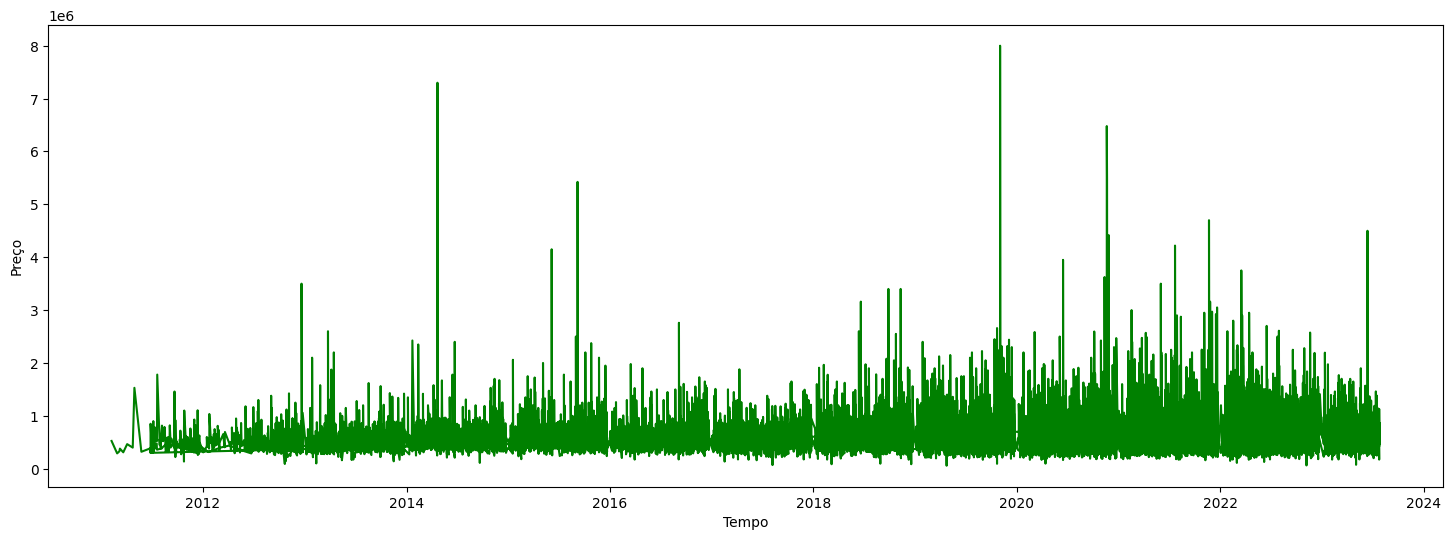

In [18]:
# Visualizando a série temporal de preço com todos os dados
plt.figure(figsize = (18,6))
plt.plot(df_dsa['preco'], color = 'green')
plt.xlabel('Tempo')
plt.ylabel('Preço')
plt.show()

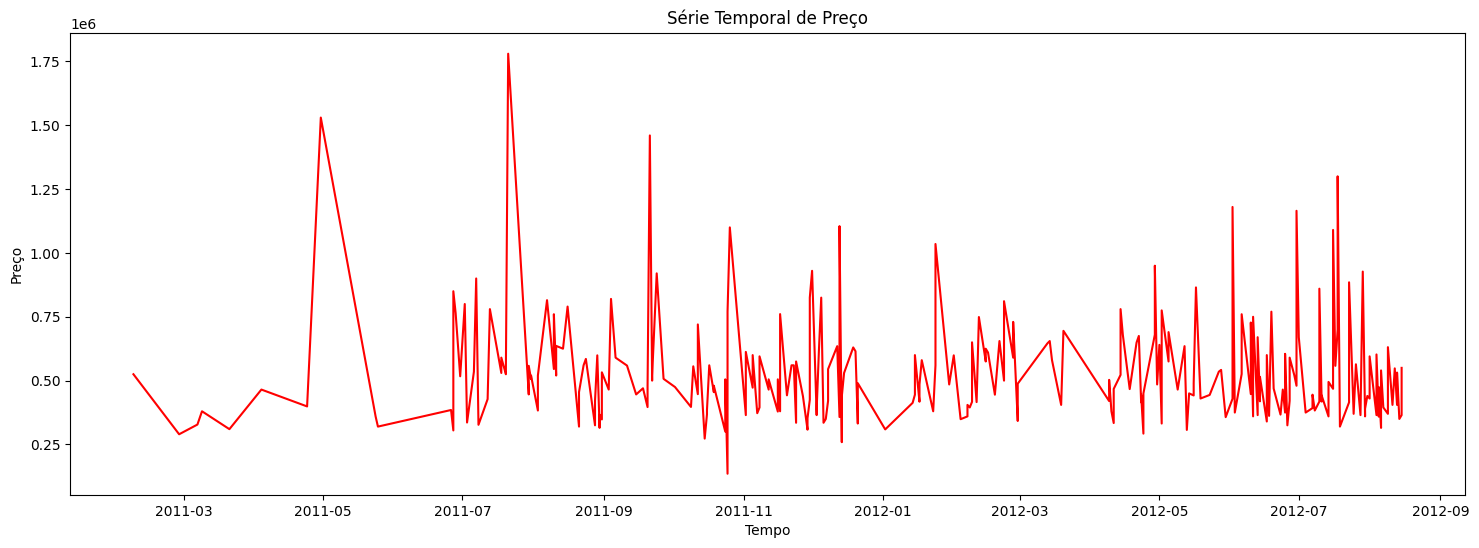

In [19]:
# Visualizando a série temporal de preço com 300 registros
plt.figure(figsize=(18,6))
plt.plot(df_dsa['preco'][:300], color = 'red')
plt.title('Série Temporal de Preço')
plt.xlabel('Tempo')
plt.ylabel('Preço')
plt.show()

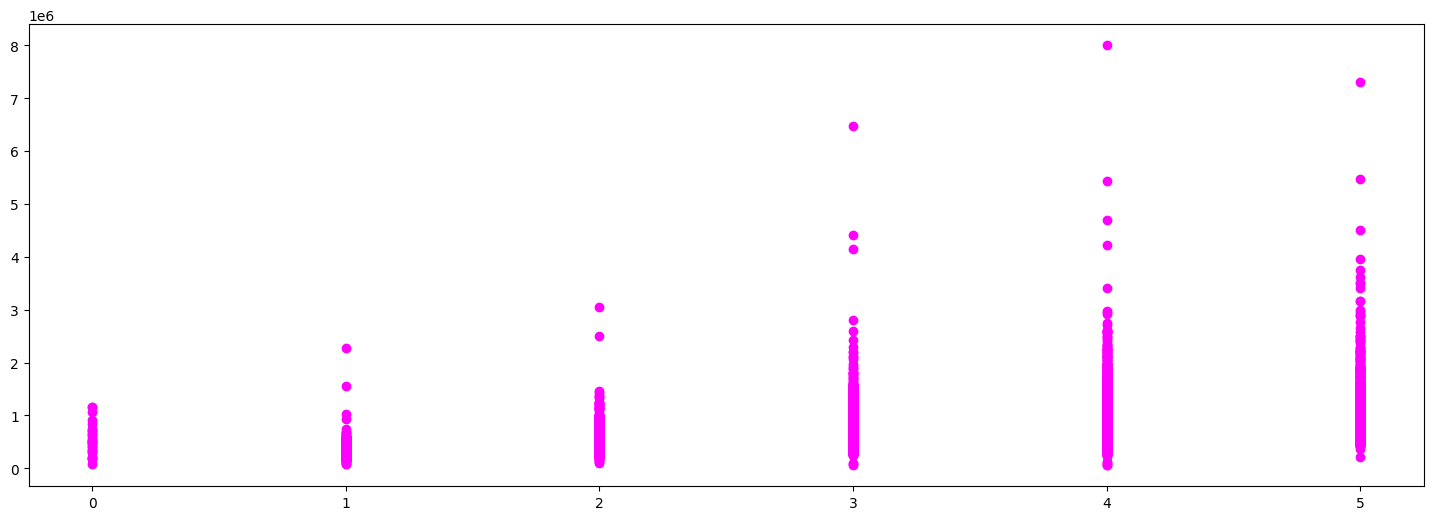

In [20]:
# Scatter Plot entre as variáveis de preço e número de quartos
plt.figure(figsize = (18,6))
plt.scatter(df_dsa['numero_quartos'], df_dsa['preco'], color = 'magenta')
plt.show()

#VERIFIDANDO A ASSIMETRIA DOS DADOS

---

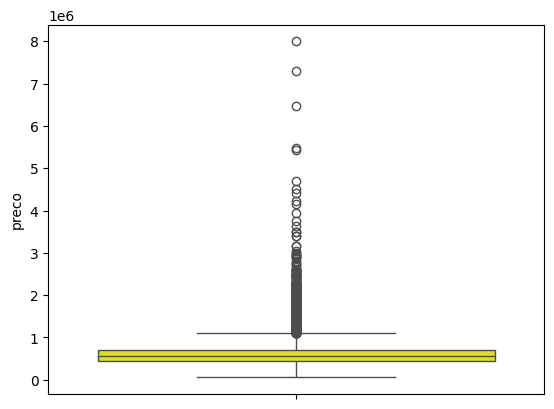

In [21]:
# Boxplot da variável de preço
sns.boxplot(df_dsa['preco'], color = 'yellow')
plt.show()

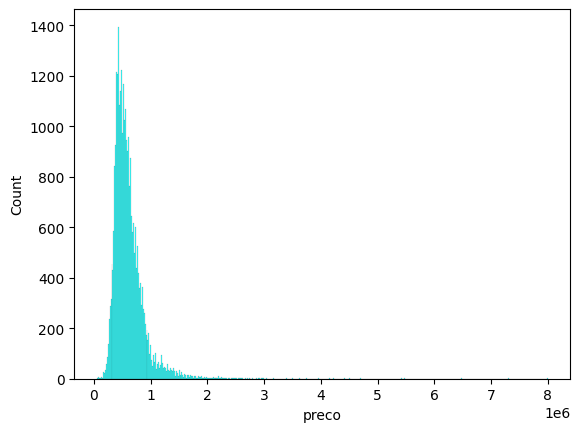

In [22]:
# Histograma da variável de preço
sns.histplot(df_dsa['preco'], color = 'cyan')
plt.show()

Os `gráficos Boxplot e Histograma` indicam forte assimetria à direita, o que é uma distribuição de dados ruim. Para remover a assimetria, `podemos usar uma simples transformação de log`.

Explicação:

`Foi detectada uma forte assimetria à direita nos dados, o que sugere que os valores estão concentrados à esquerda da distribuição`, com uma cauda longa se estendendo para a direita. Isso é frequentemente considerado indesejável em análises estatísticas, pois pode influenciar de forma negativa a interpretação dos resultados.

`Uma “distribuição de dados ruim”, não significa intrinsecamente que os dados são inválidos ou inúteis`, mas sim que a distribuição dos dados pode não atender às premissas de determinados métodos estatísticos, especialmente aqueles que assumem normalidade na distribuição dos dados.

 `A transformação de log é uma técnica comum usada para lidar com distribuições assimétricas à direita`. Ela pode ajudar a "suavizar" a assimetria e trazer os dados para uma escala mais uniforme e simétrica, tornando-os mais aptos para análises que assumem normalidade.

#TRANSFORMAÇÃO DE LOG

---

In [23]:
df_dsa.columns

Index(['preco', 'tipo_imovel', 'numero_quartos'], dtype='object')

In [24]:
# Aplica a transformação de log
df_dsa['preco'] = np.log(df_dsa['preco'])

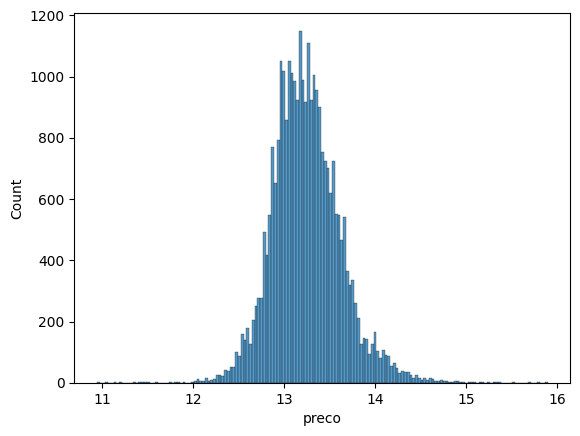

In [25]:
# Histograma
sns.histplot(df_dsa['preco'])
plt.show()

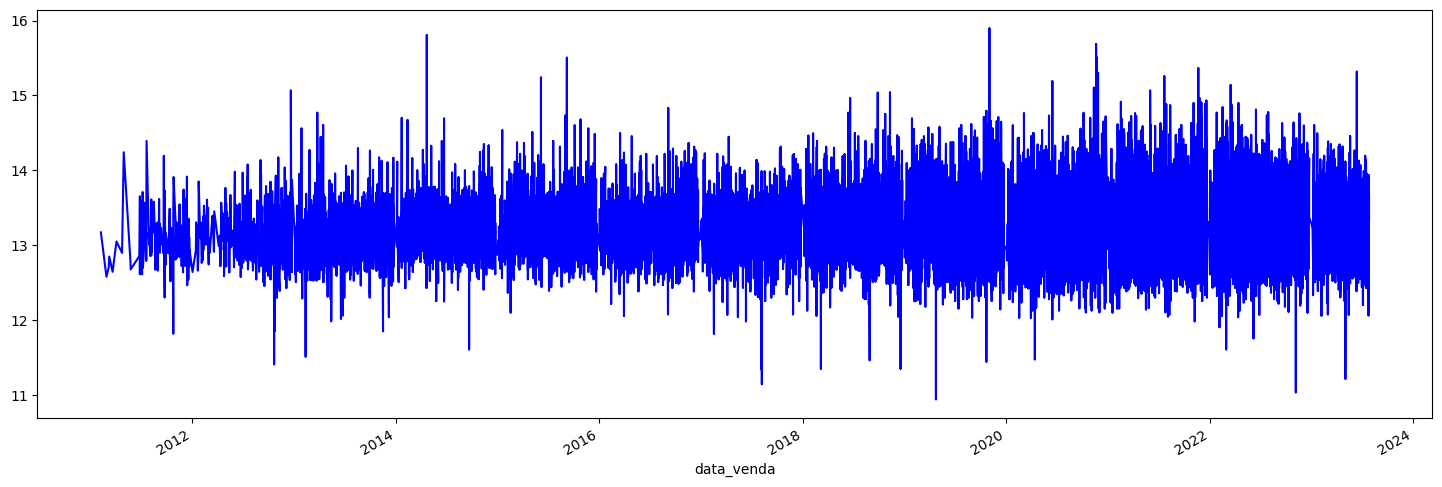

In [26]:
# Plot da variável
df_dsa.preco.plot(figsize = (18,6), color = 'blue')
plt.show()

In [27]:
# Tipos de dados
df_dsa.dtypes

preco             float64
tipo_imovel        object
numero_quartos      int64
dtype: object

In [28]:
df_dsa.head()

,preco,tipo_imovel,numero_quartos
data_venda,,,
2011-02-07,13.171154,casa,4
2011-02-27,12.577636,casa,3
2011-03-07,12.700769,casa,3
2011-03-09,12.847927,casa,4
2011-03-21,12.644328,casa,3


#ESTRATÉGIA DE TRATAMENTO DA SÉRIE TEMPORAL IRREGULAR

Como o conjunto de dados não contém dados regulares/diários, podemos usar dados médios mensais. Isso nos dará pelo menos dados regulares.

In [29]:
# Aplica o encoding na variável categórica para convertê-la em numérica
df_dsa['tipo_imovel'] = LabelEncoder().fit_transform(df_dsa['tipo_imovel'])

In [30]:
df_dsa.head()

,preco,tipo_imovel,numero_quartos
data_venda,,,
2011-02-07,13.171154,1,4
2011-02-27,12.577636,1,3
2011-03-07,12.700769,1,3
2011-03-09,12.847927,1,4
2011-03-21,12.644328,1,3


In [31]:
# Reamostrando a série para que seja mensal
df_dsa = df_dsa.resample('m').mean()

In [32]:
df_dsa.head(10)

,preco,tipo_imovel,numero_quartos
data_venda,,,
2011-02-28,12.874395,1.000000,3.500000
2011-03-31,12.731008,1.000000,3.333333
2011-04-30,13.395763,1.000000,3.666667
2011-05-31,12.733577,1.000000,3.000000
2011-06-30,13.076171,0.833333,3.333333
2011-07-31,13.195712,0.842105,3.263158
2011-08-31,13.092396,0.913043,3.391304
2011-09-30,13.154373,0.700000,3.300000
2011-10-31,13.037159,0.900000,3.300000


Temos um problema aqui

In [33]:
# A variável tipo de imóvel não pode ser agrupada adequadamente por mês. Vamos removê-la.
df_dsa.drop('tipo_imovel', axis = 1, inplace = True)

In [34]:
df_dsa.head()

,preco,numero_quartos
data_venda,,
2011-02-28,12.874395,3.500000
2011-03-31,12.731008,3.333333
2011-04-30,13.395763,3.666667
2011-05-31,12.733577,3.000000
2011-06-30,13.076171,3.333333


In [35]:
# Ajustando o valor da variável numero_quartos
for i in range(len(df_dsa['numero_quartos'])):
    df_dsa['numero_quartos'][i] = np.round(df_dsa['numero_quartos'][i])

In [36]:
df_dsa = df_dsa.dropna()

In [37]:
df_dsa.head()

,preco,numero_quartos
data_venda,,
2011-02-28,12.874395,4.0
2011-03-31,12.731008,3.0
2011-04-30,13.395763,4.0
2011-05-31,12.733577,3.0
2011-06-30,13.076171,3.0


In [38]:
df_dsa.tail()

,preco,numero_quartos
data_venda,,
2023-03-31,13.311664,3.0
2023-04-30,13.314660,3.0
2023-05-31,13.303070,3.0
2023-06-30,13.371549,3.0
2023-07-31,13.218317,3.0


#DECOMPOSIÇÃO DA SERIE TEMPORAL

---

In [39]:
resultado = seasonal_decompose(df_dsa['preco'])

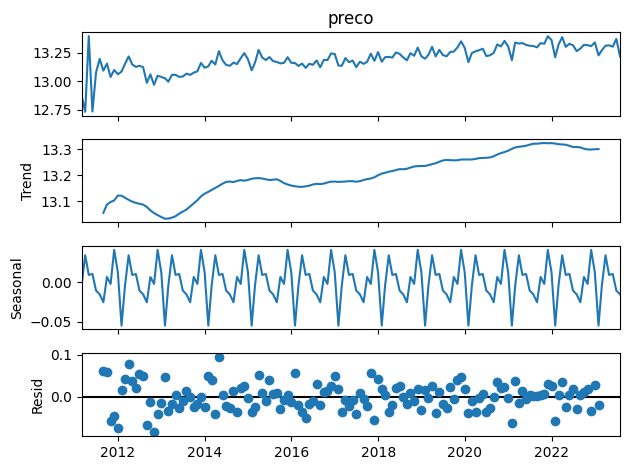

In [40]:
resultado.plot();

Este gráfico indica que o preço está em alta ao longo do tempo e também há sazonalidade.

<Axes: xlabel='data_venda'>

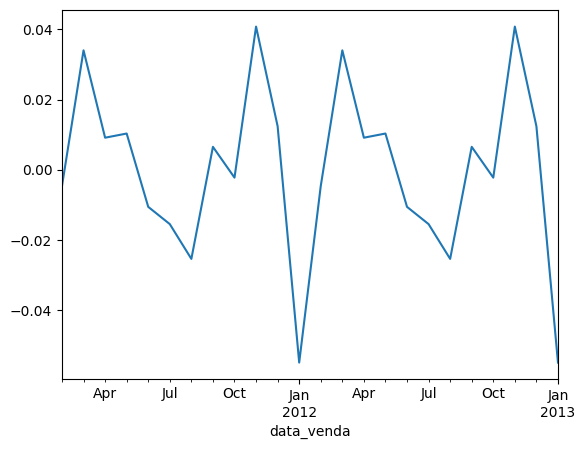

In [41]:
resultado.seasonal[:24].plot()


#ENGENHARIA DE ATRIBUTOS

---

Vamos adicionar mais duas variáveis de entrada (mais 2 atributos), ano e mês.

In [42]:
df_dsa.head()


,preco,numero_quartos
data_venda,,
2011-02-28,12.874395,4.0
2011-03-31,12.731008,3.0
2011-04-30,13.395763,4.0
2011-05-31,12.733577,3.0
2011-06-30,13.076171,3.0


In [43]:
# Extrai o ano e o mês
df_dsa['ano'] = df_dsa.index.year
df_dsa['mes'] = df_dsa.index.month

In [44]:
df_dsa.head()

,preco,numero_quartos,ano,mes
data_venda,,,,
2011-02-28,12.874395,4.0,2011,2
2011-03-31,12.731008,3.0,2011,3
2011-04-30,13.395763,4.0,2011,4
2011-05-31,12.733577,3.0,2011,5
2011-06-30,13.076171,3.0,2011,6


#DIVISAO DOS DADOS EM TREINO E TESTE

---

In [82]:
# Cria o índice para divisão 70/30
indice = int(len(df_dsa)*.7)

In [83]:
print(len(df_dsa), indice)


150 105


In [84]:
# Dados de treino (mantendo a sequência)
dados_treino = df_dsa.iloc[:indice]

In [48]:
dados_treino.tail(1)

,preco,numero_quartos,ano,mes
data_venda,,,,
2019-10-31,13.296874,3.0,2019,10


In [85]:
# Dados de teste (mantendo a sequência)
dados_teste = df_dsa.iloc[indice:]

In [86]:
dados_teste.head(1)

,preco,numero_quartos,ano,mes
data_venda,,,,
2019-11-30,13.349959,3.0,2019,11


In [87]:
dados_teste.tail(1)

,preco,numero_quartos,ano,mes
data_venda,,,,
2023-07-31,13.218317,3.0,2023,7


Agora preparamos os dados de entrada e saída. Vamos treinar o modelo como um problema de aprendizado supervisionado.

In [88]:
# Dados de entrada são os atributos
dados_entrada_treino = dados_treino.drop(columns = ['preco'])

In [89]:
dados_entrada_treino.head()

,numero_quartos,ano,mes
data_venda,,,
2011-02-28,4.0,2011,2
2011-03-31,3.0,2011,3
2011-04-30,4.0,2011,4
2011-05-31,3.0,2011,5
2011-06-30,3.0,2011,6


In [90]:
# A variável preco é o que desejamos prever e será nossa variável de saída
dados_saida_treino = dados_treino[['preco']]

In [91]:
dados_saida_treino.head()

,preco
data_venda,
2011-02-28,12.874395
2011-03-31,12.731008
2011-04-30,13.395763
2011-05-31,12.733577
2011-06-30,13.076171


# Primeira Versão do Modelo com LGBM

---

In [92]:
# Cria o modelo
modelo_v1 = LGBMRegressor()

In [93]:
# Treina o modelo
modelo_v1.fit(dados_entrada_treino, dados_saida_treino)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23
[LightGBM] [Info] Number of data points in the train set: 105, number of used features: 2
[LightGBM] [Info] Start training from score 13.151420
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

LGBMRegressor()

In [94]:
# Dados de teste para entrada e saída
dados_entrada_teste = dados_teste.drop(columns = ['preco'])
dados_saida_teste = dados_teste[['preco']]

In [96]:
# Previsões com dados de teste
previsoes_v1 = modelo_v1.predict(dados_entrada_teste)

In [97]:
# Aplica a inversa da transformação de log nas previsões
previsoes_v1 = np.exp(previsoes_v1)

In [98]:
# Aplica a inversa da transformação de log nos dados de reais
dados_saida_teste = np.exp(dados_saida_teste)

In [99]:
# Erro
print(mean_absolute_error(dados_saida_teste, previsoes_v1))

41083.66076755184


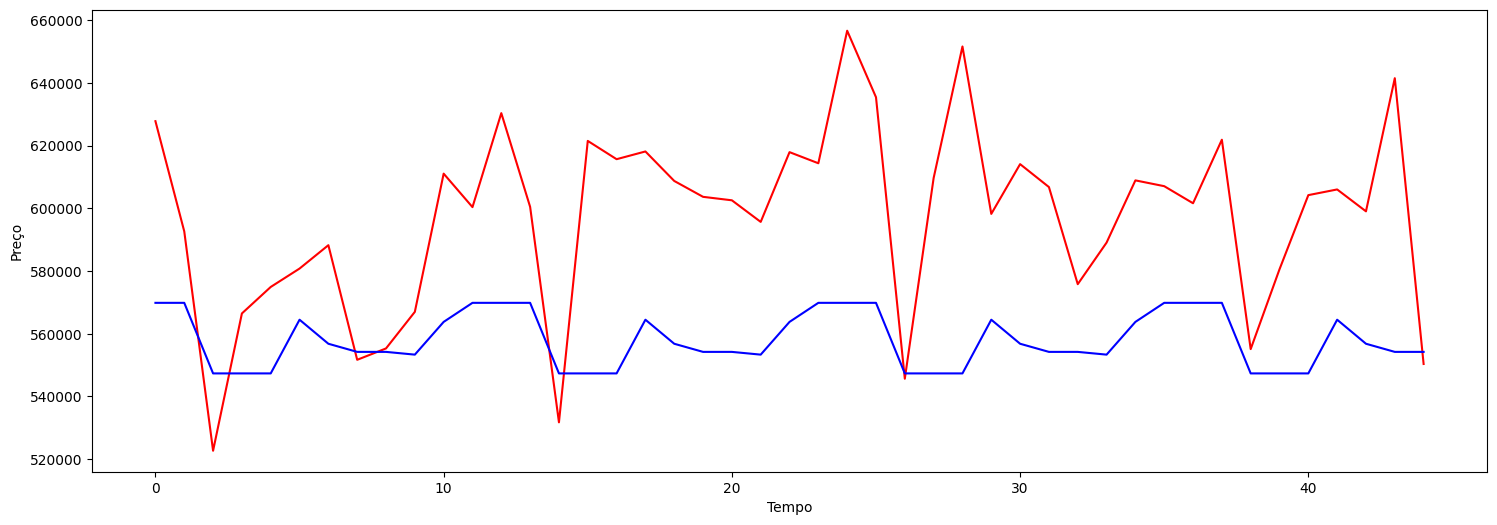

In [100]:
# Plot
plt.figure(figsize = (18,6))
plt.plot(np.array(dados_saida_teste), color = 'red')
plt.plot(np.array(previsoes_v1), color = 'blue')
plt.xlabel('Tempo')
plt.ylabel('Preço')
plt.show()

#SEGUNDA VERSÃO DO MODELO COM REGRESSÃO LINEAR

-----

In [101]:
# Cria o modelo
modelo_v2 = LinearRegression()

In [102]:
# Treina o modelo
modelo_v2.fit(dados_entrada_treino, dados_saida_treino)

LinearRegression()

In [103]:
# Entrada e saída
dados_entrada_teste = dados_teste.drop(columns = ['preco'])
dados_saida_teste = dados_teste[['preco']]

In [104]:
# Previsões
previsoes_v2 = modelo_v2.predict(dados_entrada_teste)

In [79]:
# Desfaz a transformação de log
previsoes_v2 = np.exp(previsoes_v2)

In [105]:
print(mean_absolute_error(dados_saida_teste, previsoes_v2))

0.0385591848713356


#O modelo esta performando bem.

Na DSA, o instrutor indicou o mean_absolute_error com 22987.62 e o meu deu 0.03. Pelo instrutor quanto menor o valor de mean_absolute_error

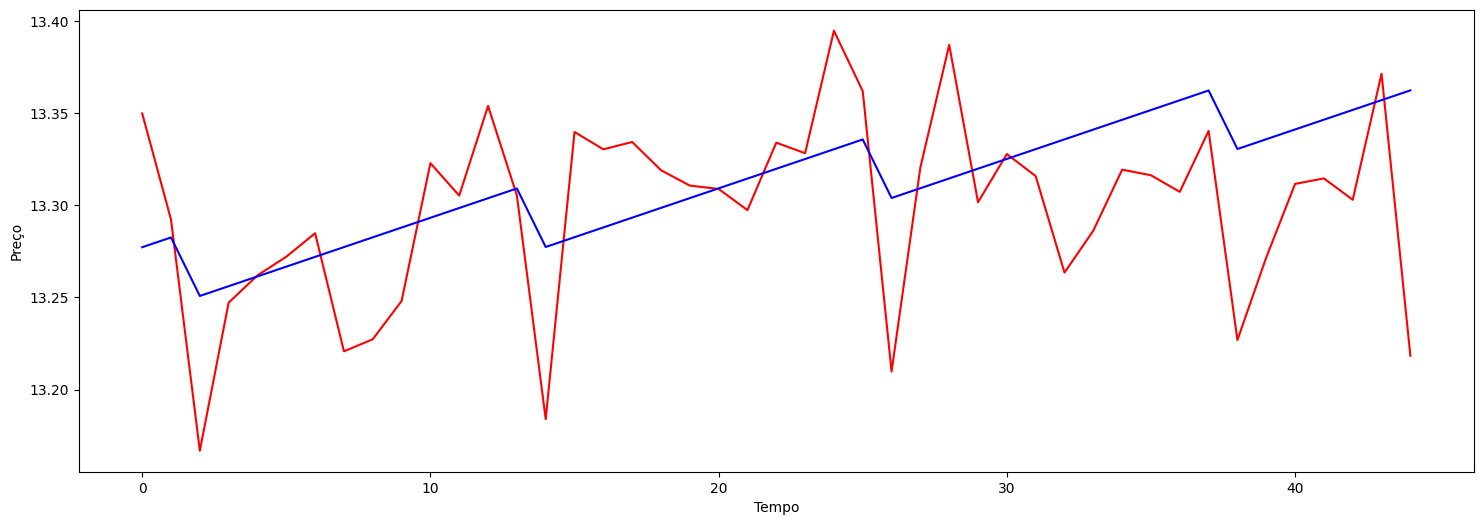

In [106]:
# Plot
plt.figure(figsize = (18,6))
plt.plot(np.array(dados_saida_teste), color = 'red')
plt.plot(np.array(previsoes_v2), color = 'blue')
plt.xlabel('Tempo')
plt.ylabel('Preço')
plt.show()

In [107]:
# Salva o modelo em disco
import joblib
filename = 'modelo_v2.sav'
joblib.dump(modelo_v2, filename)

['modelo_v2.sav']

# FORECAST COM O MELHOR MODELO

---

In [108]:
dados_entrada_teste.tail(1)

,numero_quartos,ano,mes
data_venda,,,
2023-07-31,3.0,2023,7


In [109]:
dados_saida_teste.tail(1)

,preco
data_venda,
2023-07-31,13.218317


In [111]:
# Novos dados para a previsão
novos_dados = {
    'numero_quartos': [4.0],
    'ano': [2023],
    'mes': [8]
}

In [112]:
# Índice
data_index = pd.to_datetime('2023-08-31')

In [113]:
# Cria o dataframe
df_novos_dados = pd.DataFrame(novos_dados, index = [data_index])

In [114]:
# Dataframe
df_novos_dados.head()

,numero_quartos,ano,mes
2023-08-31,4.0,2023,8


In [115]:
# Carrega o modelo do disco
modelo_dsa_final = joblib.load(filename)

In [116]:
# Previsão do modelo
previsao_preco = modelo_dsa_final.predict(df_novos_dados)

In [117]:
previsao_preco

array([[13.46746194]])

In [118]:
# Desfaz a transformação de log
previsao_preco = np.exp(previsao_preco)

In [119]:
previsao_preco

array([[706064.55013595]])

In [120]:
# Acessando o valor e formatando a string
arr = previsao_preco
valor = arr[0][0]  # Acessa o valor no array
print(f"Este é o preço previsto do imóvel: {valor:.2f}")

Este é o preço previsto do imóvel: 706064.55


##FIM

---